# Notebook made by  

__Name(s)__: Afra Baas & Stijn Hamerslag & Isa-Ali Kirca & Juno Prent

__Student id(s)__ : 12417505 & 1323795 & 12014672 & 11915307


__This notebook has been made to plot the results. Please keep in mind that:__

> This is only applicable if the provided datasets are used (german, compas and drug).

> Make sure to run the attacks with epsilons from 0.1 up to 1, otherwise it will most likely throw errors.

> Make sure to run it for all three the attacks. Since the code is written to plot 9 figures (mean, max and last) for all three the metrics.

In [1]:
import glob
import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [3]:
# seed still needs to be implemented
def get_test_dicts(dataset, data_choice, methods, folder_measure, measure):
    # make the dicts
    mean_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    max_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    last_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    # find all the files for the dataset
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, folder_measure)):
        for method in methods:
            if method in file_name:
                # strip the methods (/IAF-) etc. 
                meth = method[1:-1]
                splits = file_name.split("_")
                # find the epsilon in the filename 
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                # if there are nans in the data, skip them
                measured = data[~data[measure].isna()][measure]
                
                if measure == "test_acc":
                    # calculate test error
                    mean_dict[meth][epsilon] = np.mean(1 - measured)
                    max_dict[meth][epsilon] = (1-measured).max()
                    last_dict[meth][epsilon] = 1 - measured[measured.index[-1]]
                    
                else:
                    mean_dict[meth][epsilon] = np.mean(measured)
                    max_dict[meth][epsilon] = measured.max()
                    last_dict[meth][epsilon] = measured[measured.index[-1]] 

    return mean_dict, max_dict, last_dict 


# same holds for this function, but this time we save the iterations and time taken
# which you have to run once for the time and one for the iterations
def get_time_and_it_dicts(dataset, data_choice, methods, time_and_it_folder, t_i_col):
    dict_ = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, time_and_it_folder)):
        for method in methods:
            if method in file_name:
                meth = method[1:-1]
                splits = file_name.split("_")
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                measured = data[~data[t_i_col].isna()][t_i_col]
                
                dict_[meth][epsilon] = measured[measured.index[-1]]
    return dict_

In [4]:
def plot_seed(dataset, data_choice, methods, folder_measure, measure, time_and_it, t_i_col):    
    # ta = test accuracy
    mean_ta_dict, max_ta_dict, last_ta_dict = get_test_dicts(dataset, data_choice, methods, 
                                                             folder_measure[0], measures[0])

    # concat all three dicts into one df
    acc_df = pd.concat({'mean_acc': pd.DataFrame(mean_ta_dict), 'max_acc': pd.DataFrame(max_ta_dict), 
                        'last_acc': pd.DataFrame(last_ta_dict)}).unstack(0).sort_index(axis = 0)
    

    # p = parity
    mean_p_dict, max_p_dict, last_p_dict = get_test_dicts(dataset, data_choice, methods, 
                                                          folder_measure[1], measure[1])
    # concat all three dicts into one df
    p_df = pd.concat({'mean_par': pd.DataFrame(mean_p_dict), 'max_par': pd.DataFrame(max_p_dict), 
                      'last_par': pd.DataFrame(last_p_dict)}).unstack(0).sort_index(axis = 0)

    # b = biases
    mean_b_dict, max_b_dict, last_b_dict = get_test_dicts(dataset, data_choice, methods, 
                                                          folder_measure[1], measure[2])
    # concat all three dicts into one df
    b_df = pd.concat({'mean_bias': pd.DataFrame(mean_b_dict), 'max_bias': pd.DataFrame(max_b_dict), 
                      'last_bias': pd.DataFrame(last_b_dict)}).unstack(0).sort_index(axis = 0)
    
    # to be able to make a plot loop
    dfs = [acc_df, p_df, b_df]
    
    ylabels = ["Test error", "Statistical parity", "Equality of opportunity"]
    lines = ['b-s', 'g-^', 'r-D']
    fig, axs = plt.subplots(3,3, figsize=(15, 10))
    axs = axs.ravel()
    
    fig.suptitle("{} - {}".format(data_choice, dataset), fontsize=20)
    
    for i in range(9):
        a = 0
        for j in range(0,9,3):
            t = i % 3
            
            # makes sure everything works as it has to
            if i <= 2:
                j += 0
            elif i > 2 and i <= 5:
                j += 1  
            elif i > 5:
                j += 2
                
            col = dfs[t].columns[j]
            column_data = dfs[t][col]

            axs[i].plot(column_data, lines[a], label="{}".format(column_data.name[0]))
            axs[i].set_title("{}".format(column_data.name[1]))
            axs[i].set_xlabel('Epsilon')
            
            if "acc" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[0])
            elif "par" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[1])
            else:
                axs[i].set_ylabel(ylabels[2])
            
            axs[i].legend()
            axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    
            a += 1
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()
    
    # show time taken and number of iterations in a dataframe
    time_taken = get_time_and_it_dicts(dataset, data_choice, methods, time_and_it, t_i_col[0])
    last_iter = get_time_and_it_dicts(dataset, data_choice, methods, time_and_it, t_i_col[1])
    
    time_taken = pd.DataFrame(time_taken).sort_index(axis=0)
    last_iter = pd.DataFrame(last_iter).sort_index(axis=0)
    display(pd.concat({"Time taken in seconds": time_taken, "Number of iterations": last_iter}).unstack(0))
    print()

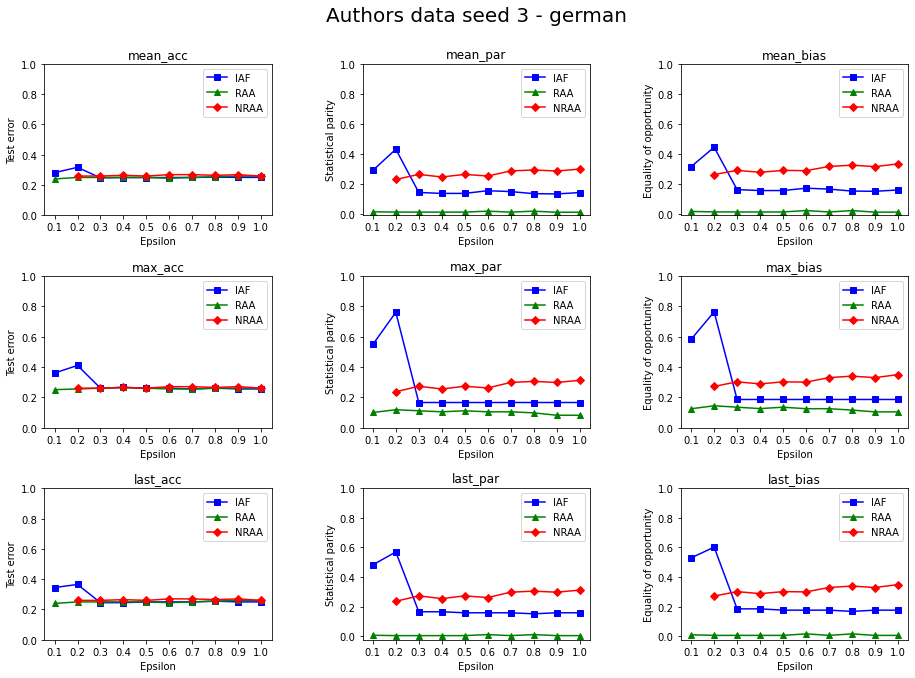

IAF                                        RAA  \
    Time taken in seconds Number of iterations Time taken in seconds   
0.1            190.247290                 88.0             41.336802   
0.2            272.345035                 98.0             50.674572   
0.3             66.901427                 28.0             46.569953   
0.4             69.685345                 28.0             50.153517   
0.5             72.963255                 28.0             58.004897   
0.6            222.469227                118.0             48.996967   
0.7            119.619046                 58.0             66.021315   
0.8             70.917205                 28.0             54.606996   
0.9             73.897584                 28.0             54.166596   
1.0             85.711616                 38.0             51.285901   

                                          NRAA                       
    Number of iterations Time taken in seconds Number of iterations  
0.1                 28.0                   NaN                  NaN  
0.2                 28.0            122.046932                 28.0  
0.3                 28.0            110.227864                 28.0  
0.4                 28.0            119.823778                 28.0  
0.5                 28.0            112.498502                 28.0  
0.6                 28.0            129.032577                 28.0  
0.7                 28.0            115.898687                 28.0  
0.8                 28.0            108.428911                 28.0  
0.9                 28.0            115.197590                 28.0  
1.0                 28.0            116.339170                 28.0

In [11]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed("german", "Authors data seed 3", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)

Make sure you **change the dataset name and data_choice** (original data or authors data). So only the first two parameters of plot_seed. The model automatically saves the dataset name and data choice as:

    - dataset: x seed y
    - dataset_choice: z
    
with:

**x**: $\left\{\begin{array}{l}\text{Original data} \;\;\;\;\;\; \text { if  x == --original_data y} \;\; \text{OR} \;\; \text{x == --original_data yes} \\ \text{Authors data} \;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**y**: $\left\{\begin{array}{l}y \in \{1,2,3\} \;\;\;\;\;\; \text { if  y == --rand_seed 1} \;\; \text{OR} \;\; \text{y == --rand_seed 2} \;\; \text{OR} \;\; \text{y == --rand_seed 3} \\ \text{0} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**z**: $z \in \{ \text{german, compas, drug}\}$

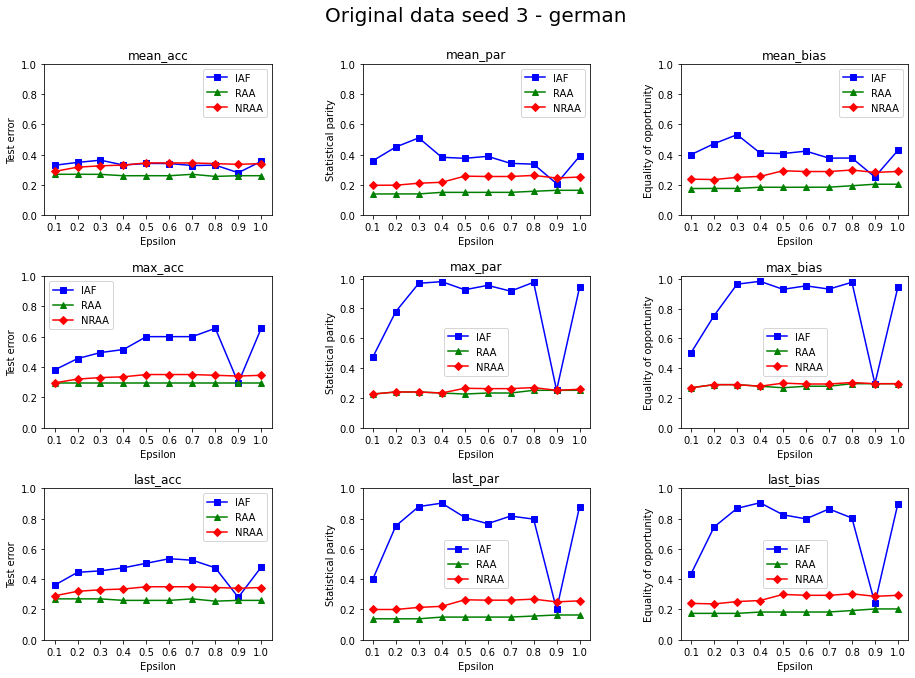

IAF                                        RAA  \
    Time taken in seconds Number of iterations Time taken in seconds   
0.1            331.498821                158.0             43.654133   
0.2            270.747433                108.0             49.564020   
0.3            372.167168                148.0             59.922155   
0.4            440.711147                198.0             46.956075   
0.5            465.577980                208.0             43.920397   
0.6            406.707692                178.0             45.572897   
0.7            454.097558                208.0             50.264914   
0.8            660.684850                318.0             52.282824   
0.9            212.244541                118.0             56.352922   
1.0            437.949396                198.0             47.709888   

                                          NRAA                       
    Number of iterations Time taken in seconds Number of iterations  
0.1                 28.0            102.261611                 28.0  
0.2                 28.0            100.795366                 28.0  
0.3                 28.0            102.432850                 28.0  
0.4                 28.0            108.076083                 28.0  
0.5                 28.0            101.232886                 28.0  
0.6                 28.0            104.282771                 28.0  
0.7                 28.0            110.107365                 28.0  
0.8                 28.0            103.172827                 28.0  
0.9                 28.0            103.585583                 28.0  
1.0                 28.0             98.524100                 28.0

In [12]:
# make sure to change the first two parameters and uncomment the line below
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed("german", "Original data seed 3", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)